# Setup for getting Reproducible results

In [6]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib

In [7]:
os.environ['PYTHONHASHSEED'] = '0'

# setting the seed for numpy
np.random.seed(2108)

# setting the seed for python random numbers
random.seed(2108)

# setting the seed for tensorflow
tf.set_random_seed(2108)

from keras import backend as K

# Force tensorflow to use a single thread
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph = tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Loading the Default Variables

In [8]:
print(os.listdir("input"))

['train_labels.csv', '.DS_Store', 'test', 'train', 'validation', 'sample_submission.csv']


In [9]:
TRAIN_DIR = "input/train"
VALIDATION_DIR = "input/validation"
TEST_DIR = "input/test"
IMG_SIZE = 150
BATCH_SIZE = 32
DROP_PROB = 0.7

# Using a pretrained VGG 16 Model

referred from
https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

## Importing required Libraries

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.models import load_model

In [7]:
# Here, I will use data augmentation technique
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,     
                                    rotation_range=30, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 classes = ['non-invasive', 'invasive'],
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 classes = ['non-invasive', 'invasive'],
                                                 class_mode = 'binary',
                                                 shuffle=False)

Found 1895 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Now we will download the vgg16 model

In [8]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet', 
                                          include_top=False, 
                                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000000E716FE3518> False
<keras.layers.convolutional.Conv2D object at 0x000000E716FE3780> False
<keras.layers.convolutional.Conv2D object at 0x000000E716FEEE10> False
<keras.layers.pooling.MaxPooling2D object at 0x000000E712B15FD0> False
<keras.layers.convolutional.Conv2D object at 0x000000E712B2AC88> False
<keras.layers.convolutional.Conv2D object at 0x000000E7170853C8> False
<keras.layers.pooling.MaxPooling2D object at 0x000000E71708FF28> False
<keras.layers.convolutional.Conv2D object at 0x000000E7170AE7B8> False
<keras.layers.convolutional.Conv2D object at 0x000000E717072198> False
<keras.layers.convolutional.Conv2D object at 0x000000E7173336A0> False
<keras.layers.pooling.MaxPooling2D object at 0x000000E717343EF0> False
<keras.layers.convolutional.Conv2D object at 0x000000E7170097F0> False
<keras.layers.convolutional.Conv2D object at 0x000000E7173591D0> False
<keras.layers.convolutional.Conv2D object at 0x000000E717369DD8> False
<ker

In [11]:
classifier = Sequential()

classifier.add(base_model)

In [12]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________


We will now add some of our own dense layers

In [13]:
classifier.add(Flatten())
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=1, activation='sigmoid'))

In [14]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [15]:
from keras import optimizers
sgd = optimizers.SGD(lr=1e-2, momentum=0.9)
classifier.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
filepath="model-vgg16.h5"
earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False, period=1)
callbacks_list = [checkpoint, earlystop]

In [17]:
history = classifier.fit_generator(training_set, epochs=250, validation_data = validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/250
60/60 [==============================] - 114s 2s/step - loss: 0.4274 - acc: 0.8054 - val_loss: 0.3397 - val_acc: 0.8950

Epoch 00001: val_loss improved from inf to 0.33966, saving model to model-vgg16.h5
Epoch 2/250
60/60 [==============================] - 96s 2s/step - loss: 0.2375 - acc: 0.8989 - val_loss: 0.2199 - val_acc: 0.9250

Epoch 00002: val_loss improved from 0.33966 to 0.21994, saving model to model-vgg16.h5
Epoch 3/250
60/60 [==============================] - 97s 2s/step - loss: 0.2476 - acc: 0.8974 - val_loss: 0.1948 - val_acc: 0.9300

Epoch 00003: val_loss improved from 0.21994 to 0.19477, saving model to model-vgg16.h5
Epoch 4/250
60/60 [==============================] - 97s 2s/step - loss: 0.1876 - acc: 0.9333 - val_loss: 0.1730 - val_acc: 0.9275

Epoch 00004: val_loss improved from 0.19477 to 0.17302, saving model to model-vgg16.h5
Epoch 5/250
60/60 [==============================] - 99s 2s/step - loss: 0.1859 - acc: 0.9304 - val_loss: 0.1761 - val_acc: 0.9

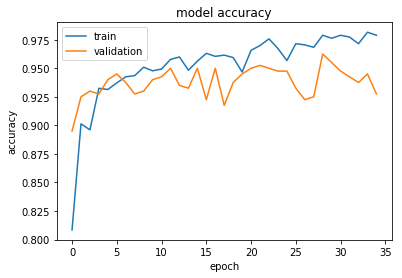

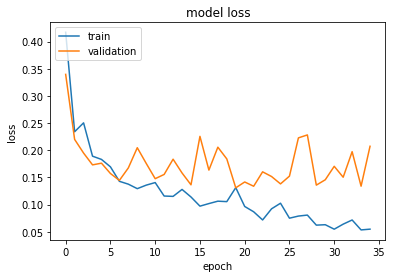

In [18]:
# taken from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
classifier

In [10]:
classifier = load_model("model-vgg16.h5")

In [12]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('input/train_labels.csv')
    
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        name = img.split('.')[0]
        path = os.path.join(TEST_DIR, img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        testing_data.append(np.array([name, np.array(img/255)], dtype=object))
    np.save('test_data-{}.npy'.format(IMG_SIZE), testing_data, allow_pickle=True)
    return testing_data

In [13]:
testing_data = None
if "test_data-{}.npy".format(IMG_SIZE) in os.listdir():
    testing_data = np.load("test_data-{}.npy".format(IMG_SIZE))
else:
    testing_data = create_test_data()

In [14]:
print(len(testing_data))

1531


In [15]:
testing_x = np.array([i[1] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
testing_name = np.array([i[0] for i in testing_data])

In [16]:
prediction_prob = list(classifier.predict(testing_x).transpose())[0]
prediction_classes = classifier.predict_classes(testing_x)

# with open('prediction_vgg16.csv', 'w') as file:
#     file.write("name,invasive\n")
#     for i,j in zip(testing_name, prediction_prob):
#         file.write(str(i)+","+str(j))
#         file.write('\n')

In [17]:
sample_submission = pd.read_csv("input/sample_submission.csv")

for i, name in enumerate(testing_name):
    sample_submission.loc[sample_submission['name'] == int(name), 'invasive'] = prediction_prob[i]

sample_submission.to_csv("prediction_vgg16.csv", index=False)

(array([782.,  62.,  33.,  11.,  22.,  24.,  14.,  18.,  25., 540.]),
 array([1.15649396e-04, 1.00104084e-01, 2.00092520e-01, 3.00080955e-01,
        4.00069390e-01, 5.00057825e-01, 6.00046260e-01, 7.00034695e-01,
        8.00023130e-01, 9.00011565e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

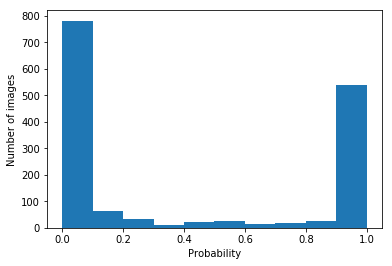

In [19]:
import matplotlib.pyplot as plt
plt.xlabel('Probability')
plt.ylabel('Number of images')
plt.hist(prediction_prob, bins = 10)

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
def visual_predictions(size):
    samples = random.sample(list(zip(testing_name, prediction_classes)),size)
    plt.figure(figsize=(18,18))
    columns = 3
    for i, (name, pred_class) in enumerate(samples):
        path = os.path.join(TEST_DIR, name+'.jpg')
        image = mpimage.imread(path)
        plt.subplot(size / columns + 1, columns, i + 1)
        plt.title(name + " -- prediction -- " + str(pred_class))
        plt.imshow(image)  

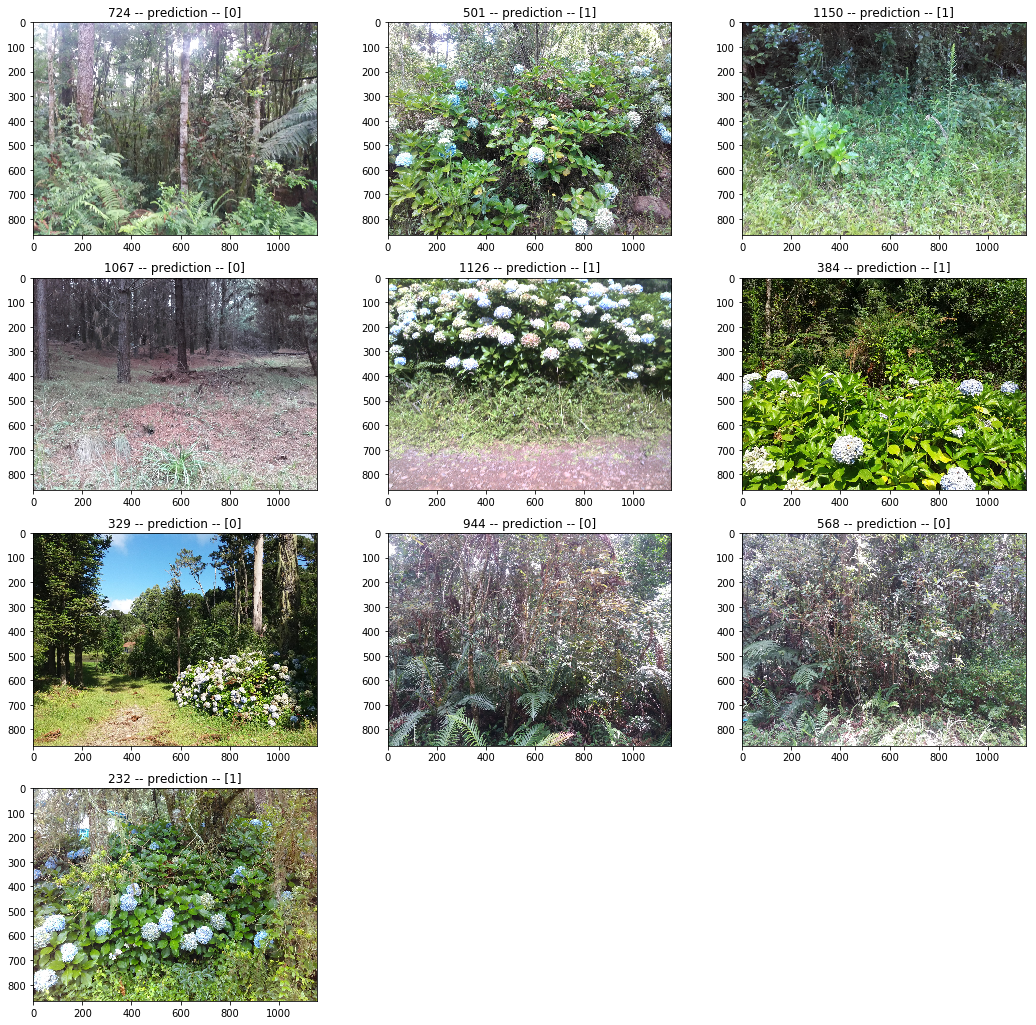

In [32]:
visual_predictions(10)

In [5]:
from keras.utils import plot_model
plot_model(classifier, to_file='vgg16-model.png')

Submission using just 25 epochs gives an roc score of 0.91812. This is quite an improvement over the basic cnn. I will keep on tweaking the architecture of the cnn and tune the model to make further improvements.

edit: The submission using 68 epochs now yields 0.93185 roc score. In this I used rmsprop as an optimizer. Next time I will try SGD Optimizer.

edit: I have now tweaked the architecture of the model too. I have set the last 4 layers of the vgg16 as trainable.
**0.97293** is the final score. This model made much improvement over the previous ones.

Now we will visually see the erroreneous predictions.

In [43]:
# Get the filenames from the generator
fnames = validation_set.filenames
# print(fnames)

# Get the ground truth from generator
ground_truth = validation_set.classes
# print(ground_truth) 

# Get the label to class mapping from the generator
label2index = validation_set.class_indices
# print(label2index)

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
print(idx2label)

{0: 'non-invasive', 1: 'invasive'}


In [46]:
# Get the predictions from the model using the generator
predictions = classifier.predict_generator(validation_set, verbose=1)

13/13 [==============================] - ETA: 24 - ETA: 18 - ETA: 15 - ETA: 13 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 16s 1s/step
<bound method Sequential.predict_classes of <keras.engine.sequential.Sequential object at 0x000000E728ED2358>>


In [75]:
prediction_classes = predictions > 0.5
prediction_classes = prediction_classes.astype(int).transpose()[0]

In [78]:
errors = np.where(prediction_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_set.samples))

No of errors = 22/400


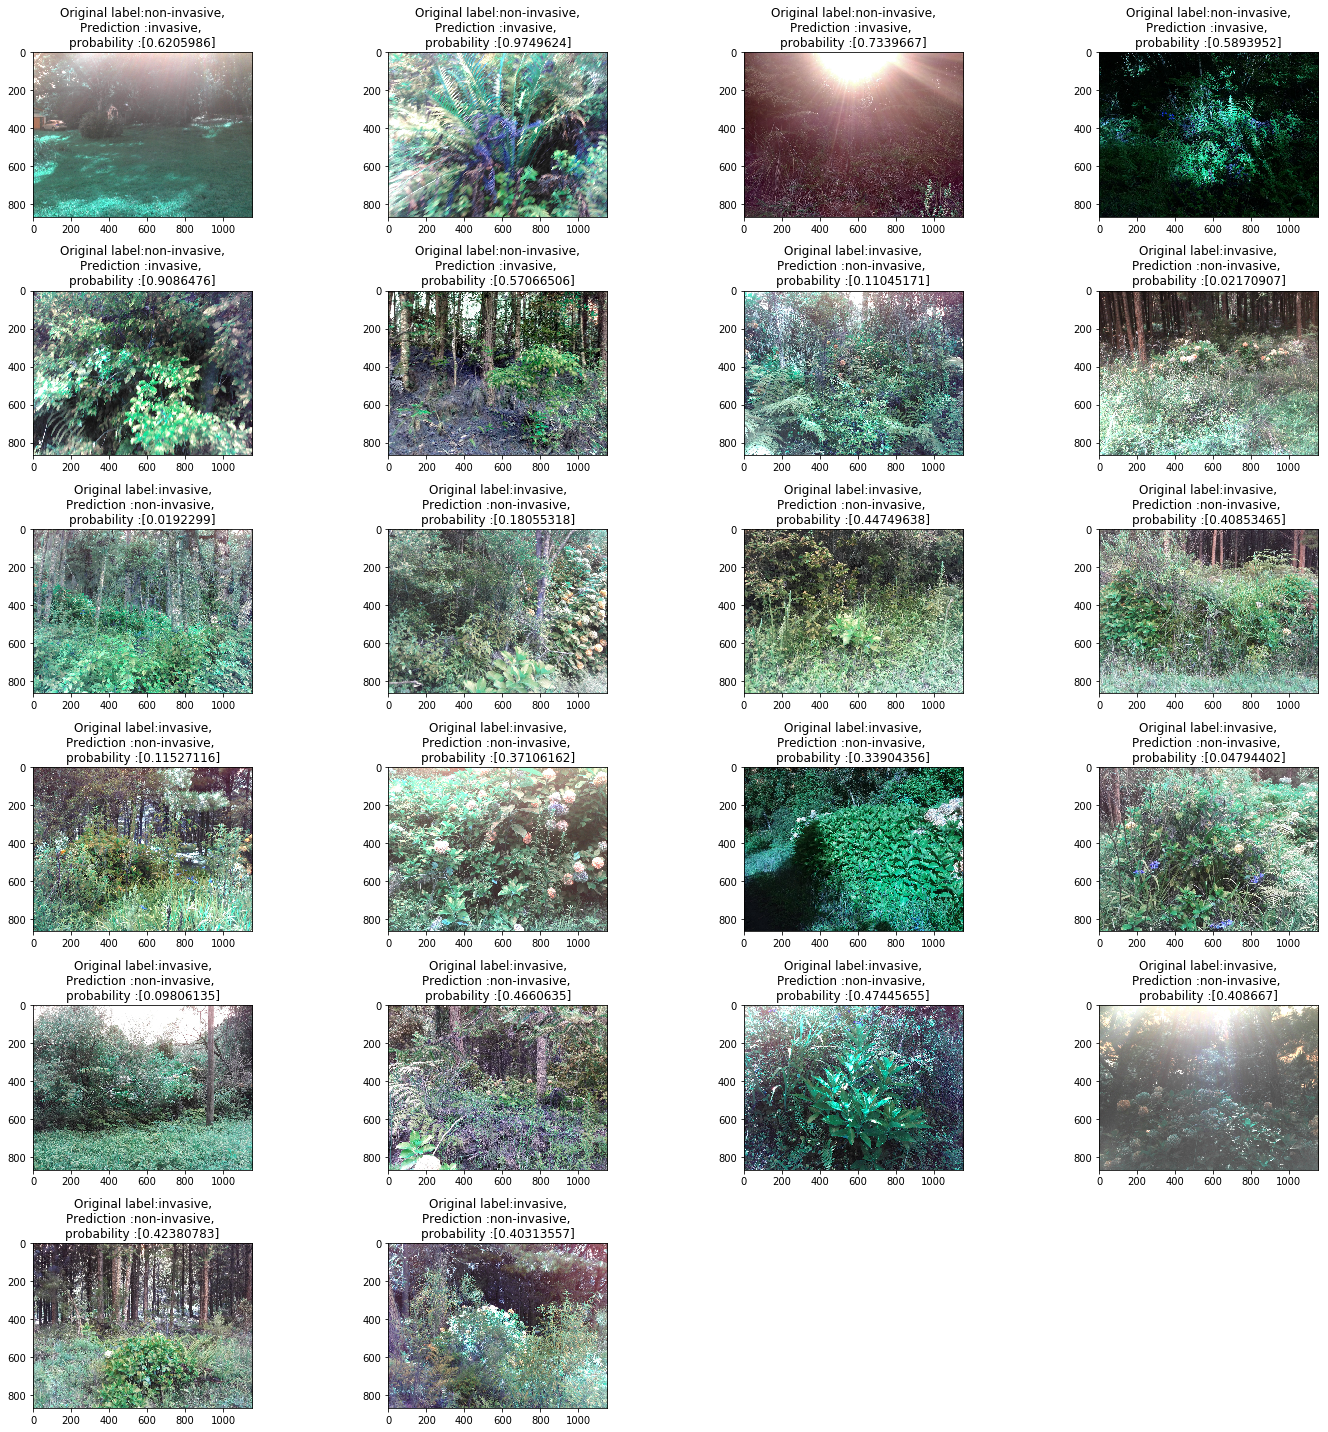

In [126]:
# Show the errors
plt.figure(figsize=(20,20))
columns = 4
for i in range(len(errors)):
    pred_class = prediction_classes[errors[i]]
    pred_label = idx2label[pred_class]
    
#     use split delimiter as '/'
    title = 'Original label:{},\nPrediction :{}, \nprobability :{}'.format(
        fnames[errors[i]].split('\\')[0],
        pred_label,
        predictions[errors[i]]
        )
    original = cv2.imread('{}/{}'.format(VALIDATION_DIR,fnames[errors[i]]))
    ax = plt.subplot(len(errors)/columns + 1, columns, i + 1)
    ax.set_title(title)
    plt.imshow(original)

plt.tight_layout()
plt.show()